## Simulation for EADA

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

In [20]:
class PowerGrid:
    def __init__(self,
                 renewable_capacity: float,
                 fossil_capacity: float,
                 base_demand: float):
        """
        Initialize power grid with energy generation capacities

        Args:
            renewable_capacity: Maximum renewable energy generation capacity (MW)
            fossil_capacity: Maximum fossil fuel energy generation capacity (MW)
            base_demand: Base power demand from non-mining sources (MW)
        """
        self.renewable_capacity = renewable_capacity
        self.fossil_capacity = fossil_capacity
        self.base_demand = base_demand

    def get_renewable_generation(self, hour: int, weather_factor: float) -> float:
        """Simulate renewable energy generation based on time of day and weather"""
        # Solar generation peaks at noon
        time_factor = np.sin(np.pi * (hour - 6) / 12) if 6 <= hour <= 18 else 0
        generation = self.renewable_capacity * time_factor * weather_factor
        return max(0, generation)

    def get_total_generation(self, hour: int, weather_factor: float) -> Dict[str, float]:
        """Calculate total power generation from all sources"""
        renewable = self.get_renewable_generation(hour, weather_factor)
        required_fossil = min(
            self.fossil_capacity,
            max(0, self.base_demand - renewable)
        )
        return {
            'renewable': renewable,
            'fossil': required_fossil,
            'total': renewable + required_fossil
        }

In [21]:
class MiningNetwork:
    def __init__(self,
                 initial_difficulty: float,
                 target_block_time: float,
                 e_threshold: float,
                 d_adjustment: float):
        """
        Initialize mining network parameters

        Args:
            initial_difficulty: Starting mining difficulty
            target_block_time: Target time between blocks (minutes)
            e_threshold: Minimum renewable energy threshold for EADA
            d_adjustment: Difficulty adjustment factor for EADA
        """
        self.difficulty = initial_difficulty
        self.target_block_time = target_block_time
        self.e_threshold = e_threshold
        self.d_adjustment = d_adjustment
        self.blocks_mined = 0
        self.energy_consumed = 0
        self.renewable_energy_used = 0

    def mine_block(self, available_power: float, renewable_ratio: float) -> Tuple[bool, float]:
        """
        Attempt to mine a block with available power

        Returns:
            Tuple of (success, energy_consumed)
        """
        # Adjusted mining model with more realistic success probability
        # Base probability scaled to achieve target block time
        base_probability = 0.1  # Baseline probability per attempt
        power_factor = available_power / (self.difficulty * 10)  # Adjusted scaling factor
        success_probability = min(base_probability * power_factor, 0.95)  # Cap at 95% probability

        success = np.random.random() < success_probability

        energy_consumed = available_power * self.target_block_time/60  # Convert to hour fraction
        if success:
            self.blocks_mined += 1
            self.energy_consumed += energy_consumed
            self.renewable_energy_used += energy_consumed * renewable_ratio

        return success, energy_consumed

In [24]:
class Simulation:
    def __init__(self):
        # Initialize power grid (capacities in MW)
        self.grid = PowerGrid(
            renewable_capacity=4000,  # 4 GW renewable capacity
            fossil_capacity=200,      # 200 MW fossil capacity
            base_demand=200          # 200 MW base demand
        )

        # Initialize two mining networks - Traditional and EADA
        self.traditional = MiningNetwork(
            initial_difficulty=50,
            target_block_time=10,
            e_threshold=0,    # Traditional doesn't use these
            d_adjustment=0    # Traditional doesn't use these
        )

        self.eada = MiningNetwork(
            initial_difficulty=50,
            target_block_time=10,
            e_threshold=0.5,  # 50% renewable threshold
            d_adjustment=0.1  # 10% difficulty adjustment
        )

    def run_simulation(self, days: int) -> pd.DataFrame:
        """Run simulation for specified number of days"""
        hours = days * 24
        results = []

        for hour in range(hours):
            # Simulate weather variations
            weather_factor = np.random.normal(0.7, 0.2)
            weather_factor = max(0, min(1, weather_factor))

            # Get power generation for this hour
            generation = self.grid.get_total_generation(hour % 24, weather_factor)

            # Calculate available power for mining
            available_power = max(0, generation['total'] - self.grid.base_demand)
            renewable_ratio = generation['renewable'] / generation['total'] if generation['total'] > 0 else 0

            # Traditional mining
            trad_success, trad_energy = self.traditional.mine_block(available_power, renewable_ratio)

            # EADA mining with adjusted difficulty
            if renewable_ratio >= self.eada.e_threshold:
                self.eada.difficulty *= (1 - self.eada.d_adjustment)
            eada_success, eada_energy = self.eada.mine_block(available_power, renewable_ratio)

            results.append({
                'hour': hour,
                'weather_factor': weather_factor,
                'renewable_generation': generation['renewable'],
                'fossil_generation': generation['fossil'],
                'renewable_ratio': renewable_ratio,
                'traditional_energy': trad_energy,
                'traditional_success': trad_success,
                'eada_energy': eada_energy,
                'eada_success': eada_success,
                'eada_difficulty': self.eada.difficulty,
                'available_power': available_power
            })

        return pd.DataFrame(results)

    def plot_results(self, results: pd.DataFrame):
        """Plot simulation results"""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

        # Plot energy generation
        results[['renewable_generation', 'fossil_generation']].plot(
            ax=ax1, title='Power Generation Over Time')
        ax1.set_ylabel('Power (MW)')
        ax1.legend(['Renewable', 'Fossil'])

        # Plot mining success rates
        success_rates = pd.DataFrame({
            'Traditional': results['traditional_success'].rolling(24).mean(),
            'EADA': results['eada_success'].rolling(24).mean()
        })
        success_rates.plot(ax=ax2, title='Block Mining Success Rate (24-hour moving average)')
        ax2.set_ylabel('Success Rate')

        # Plot cumulative energy consumption
        cumulative_energy = pd.DataFrame({
            'Traditional': results['traditional_energy'].cumsum(),
            'EADA': results['eada_energy'].cumsum()
        })
        cumulative_energy.plot(ax=ax3, title='Cumulative Energy Consumption')
        ax3.set_ylabel('Energy Consumed (MWh)')

        plt.tight_layout()
        plt.show()

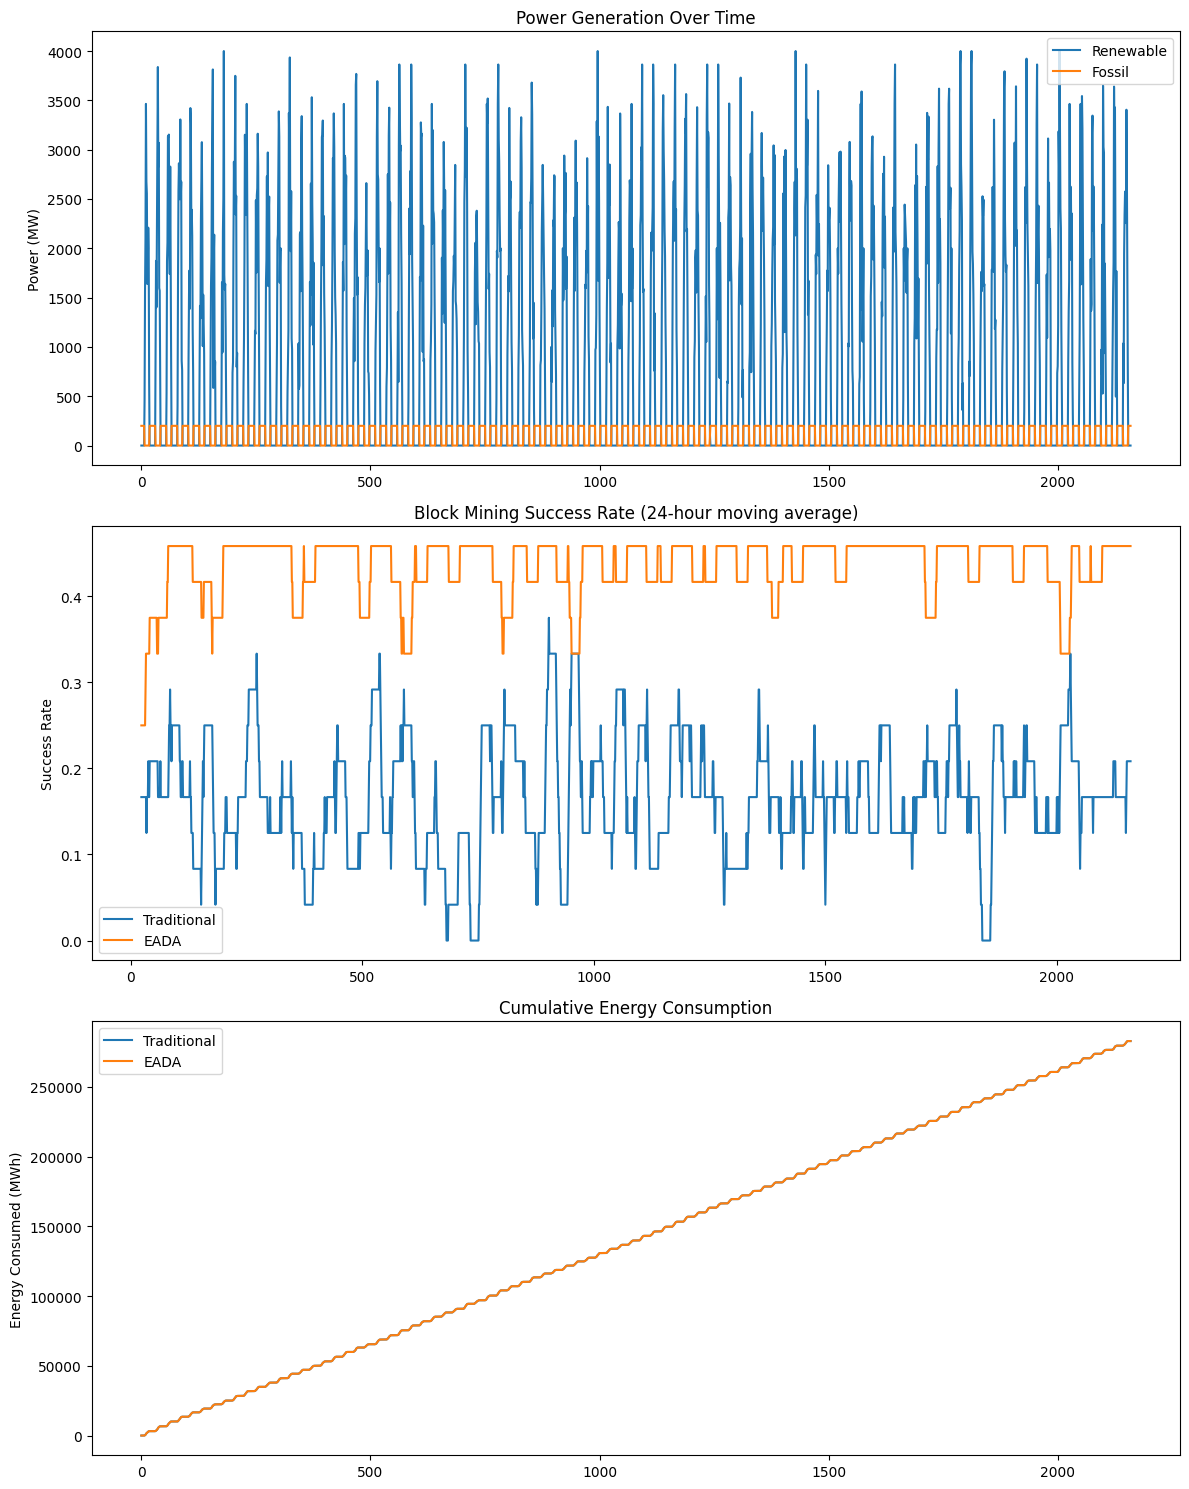


Simulation Summary:
Traditional Mining:
Total Energy Consumed: 282795.63 MWh
Blocks Mined: 355
Energy per Block: 796.61 MWh

EADA Mining:
Total Energy Consumed: 282795.63 MWh
Blocks Mined: 937
Energy per Block: 301.81 MWh

Energy Savings: 0.00%

Detailed Statistics:
Average Available Power: 785.54 MW
Average Renewable Ratio: 0.46
Traditional Mining Success Rate: 0.1644
EADA Mining Success Rate: 0.4338


In [25]:
# Run simulation
sim = Simulation()
results = sim.run_simulation(days=90)  # Simulate for 90 days
sim.plot_results(results)

# Print summary statistics
print("\nSimulation Summary:")
print(f"Traditional Mining:")
print(f"Total Energy Consumed: {results['traditional_energy'].sum():.2f} MWh")
print(f"Blocks Mined: {results['traditional_success'].sum()}")
if results['traditional_success'].sum() > 0:
    print(f"Energy per Block: {results['traditional_energy'].sum() / results['traditional_success'].sum():.2f} MWh")

print(f"\nEADA Mining:")
print(f"Total Energy Consumed: {results['eada_energy'].sum():.2f} MWh")
print(f"Blocks Mined: {results['eada_success'].sum()}")
if results['eada_success'].sum() > 0:
    print(f"Energy per Block: {results['eada_energy'].sum() / results['eada_success'].sum():.2f} MWh")

if results['traditional_success'].sum() > 0:
    print(f"\nEnergy Savings: {((results['traditional_energy'].sum() - results['eada_energy'].sum()) / results['traditional_energy'].sum() * 100):.2f}%")

# Additional statistics
print("\nDetailed Statistics:")
print(f"Average Available Power: {results['available_power'].mean():.2f} MW")
print(f"Average Renewable Ratio: {results['renewable_ratio'].mean():.2f}")
print(f"Traditional Mining Success Rate: {results['traditional_success'].mean():.4f}")
print(f"EADA Mining Success Rate: {results['eada_success'].mean():.4f}")